### Digit Recognizer challenge (Kaggle)

#### The idea of this notebook is to play with different classification algorithms in order to recognize handwritten digits from the go-to computer vision fundamentals dataset MINST

##### Steps that will be followed:
                    - Data cleaning/Formatting. 
                        - Feature scaling, is there a need? There's no need for future scaling, as all features are in the same range (0, 255)
                        - Feature engineering? No need
                        - Is the training set biased? Checked, that's not the case
                        - Data augmentation? In case having more data can be useful (high bias), create more samples from our dataset by rotating or creating images from the original dataset
                    - Split dataset into training, cv and test => Done
                    - Model architecture and optimization
                        - Choose a given model framework (logistic regression, Neuronal Network, Binary Tree)
                        - For neuronal networks, not only consider the number of layers, the neurons per layer, but also the regularization term (we could also include the learning_rate of the adam optimizer, but normally this only affects to the speed of the algorithm, not the output of it!). Higher learning rates should make the algo run faster!
                        - Start with a very simple model (high bias) and make it more complex (high variance one)
                        - Try to plot the decision boundary
                        - Compute the error on the classification as a percentage of the cv size
                        - Computes curves of Error vs parameters
                        - Compute precision and recall and F1 score.
                        - Try to analyze the errors, is there any trend? Meaning, is there any number concretely we are missclassifying more than the others (or for instance, are mumbers that are closed shaped missclassified more than the rest?). This will help us understand what the algo is lacking.
                        - Compute also main metrics as precision and recall for the algorithm
                        - Determine of the algo suffers from high bias or high variance or both 
                

The challenge specifies that the metric to be ranked will be the categorization accuracy, or in other words, the proportion of images that are correctly classified divided by the total number of predictions (TP/(TP+FN))

In [1]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,Input
from keras.losses import MeanSquaredError, BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.activations import sigmoid, relu, linear
from keras import layers,Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import utils_digit_recognition as udr

2024-04-25 15:31:54.755063: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 15:31:54.785870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 15:31:55.233519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import the data
path = "~/Code/Kaggle/Digit_Recognizer/train.csv"
train_data = pd.read_csv(path)
train_data.head(7)

# Check if there are any duplicates (no, theare are no duplicates)
sum(train_data.duplicated())

# As it can be read in the description of the project,
# the first column contains the digit, a.k.a label, 
# and the other 784 columns represent pixel values from
# 0 to 255. Every row corresponds to a single
# image, which is unfolded from a 28x28 matrix.

0

##### The very first part of the project will  be devoted to analyze our data. First of all, we'll split our data into train and cv and we will check whether our dataset is balanced (each category has the same relative frequency) and we'll plot some images to have a grasp on how the handwritten numbers are

In [3]:
# Get relative frequencies of labels
from collections import Counter
n,m = train_data.shape
categories = train_data['label'].nunique()
print(f"our train dataset contains {n} images")
print(f"where each image contains {m} pixels")
print(f"and each image can be classified as one of {categories} different handwritten numbers")
freq = train_data.groupby("label").size()/n
freq.name='relative frequencies'
freq
# As it can be observed, the relative frequencies of labels in the dataset
# is pretty much the same, which ensures we have a non-skewed training set

our train dataset contains 42000 images
where each image contains 785 pixels
and each image can be classified as one of 10 different handwritten numbers


label
0    0.098381
1    0.111524
2    0.099452
3    0.103595
4    0.096952
5    0.090357
6    0.098500
7    0.104786
8    0.096738
9    0.099714
Name: relative frequencies, dtype: float64

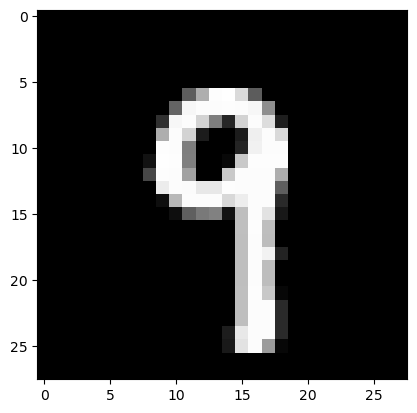

In [4]:
# We'll divide the data into a 2/3 - 1/3 split, 2/3 of it will be used 
# to compute our model parameters and 1/3 of it to fine-tune 
# the hyperparameters we're using a fixed random_state=42 to make 
# the results reproductible across multiple calls 
# (maybe good to try to remove it once we have model selected)
x_train, x_cv, y_train, y_cv = train_test_split(train_data.iloc[:,1:], train_data['label'], train_size=0.66, random_state=42)
plt.imshow(np.array(x_train.iloc[0,:]).reshape(28,28),cmap='gray', vmin=0, vmax=255)

# To-do: In case we see our algorithm experiences high bias (both J_test and J_cv are high), we can try to
# augment the input data by rotating the numbers. Mathematically, those transformations are 
# a linear transformation of what we alredy have, so co-dependence issues could arise from
# such transformation. In case we see that the algo does not improve after doing that,
# we can add some white noise to the image to make it non-linearly dependent

In [5]:
# Our first shot for a classifier will be a Dense Neuronal Network
# where we'll make use of the SparseCategoricalCrossEntropy
# loss function (Softmax function, suited for a multilabel classification problem)
# as an optimizer, we'll use Adam optimizer, just a version
# of gradient descent in which the learning rate, alpha,
# changes differently for different parameters

# For the neurons, we'll make use of achitectures with reducing
# number of nodes per layer and we'll try with three different
# values of lambda (0.1 and 10)
models = {'A_1_.1':{'nn':[10],
                    'lambda':0.1},
           'A_5_2_.1':{'nn':[50,20],
                    'lambda':0.1},
          'A_3_2_.1':{'nn':[30,20],
                    'lambda':0.1},
          'A_5_2_10.':{'nn':[50,20],
                    'lambda':10},
          'A_3_2_10.':{'nn':[30,20],
                    'lambda':10}, 
          'A_4_3_2_.1':{'nn':[40,30,20],
                        'lambda':0.1},
          'A_4_3_2_.1':{'nn':[40,20,15],
                        'lambda':0.1},
          'A_4_3_2_10':{'nn':[40,30,20],
                        'lambda':10},
          'A_4_3_2_10':{'nn':[40,20,15],
                        'lambda':10}}

#models = {'try1':{'nn':[20,15],
#                  'lambda':0.1}}
i=0
results = dict((key,()) for key in models)
for model_key,model_params in models.items():
    results[model_key] = udr.build_model_and_train(model_params,x_train,y_train,x_cv,y_cv,categories)
    i+=1
    print(f"Progress...{i/len(models)}")

Epoch 1/25


2024-04-25 15:32:08.164608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 15:32:08.165023: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - loss: 5.4566
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - loss: 2.1643
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - loss: 1.7231
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 1.3928
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 1.1586
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - loss: 1.0220
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.9673
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step - loss: 0.9219
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 0.8934
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - loss: 0.9661
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - loss: 0.8514
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - loss: 0.8006
Epoch 13/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - loss: 0.7415
Epoch 14/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - loss: 0.7268
Epoch 15/25
867/867 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,882 (93.29 KB)

 Trainable params: 7,960 (31.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,922 (62.20 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
Progress...0.14285714285714285
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - loss: 12.3357
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9177
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - loss: 1.2914
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.7095
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 0.5063
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 0.4646
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - loss: 0.4588
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 0.4588
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - loss: 0.4522
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.4544
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 0.4508
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 0.4651
Epoch 13/25
867/867 ━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,442 (474.39 KB)

 Trainable params: 40,480 (158.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,962 (316.26 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
Progress...0.2857142857142857
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 13.4265
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - loss: 2.4711
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - loss: 1.1596
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - loss: 0.6551
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - loss: 0.4909
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - loss: 0.4438
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.4487
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 0.4492
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.4454
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - loss: 0.4410
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.4390
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 0.4392
Epoch 13/25
867/867 ━━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,142 (285.71 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,762 (190.48 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
Progress...0.42857142857142855
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 238.9915
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - loss: 1.4574
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - loss: 1.3642
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 1.2923
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 1.2528
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 1.2171
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 1.2065
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - loss: 1.1591
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - loss: 1.1508
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 1.1651
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 1.1497
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - loss: 1.1276
Epoch 13/25
867/867 ━━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,442 (474.39 KB)

 Trainable params: 40,480 (158.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,962 (316.26 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
Progress...0.5714285714285714
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 185.1526
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - loss: 1.4438
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 1.3585
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 1.2838
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - loss: 1.2343
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - loss: 1.2142
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - loss: 1.1669
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 1.1770
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 1.1399
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 1.1265
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 1.1413
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 1.1133
Epoch 13/25
867/867 ━━━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,142 (285.71 KB)

 Trainable params: 24,380 (95.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 48,762 (190.48 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
Progress...0.7142857142857143
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - loss: 11.9919
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - loss: 2.5526
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 1.0732
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.7091
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 0.5892
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 0.5480
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - loss: 0.5237
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step - loss: 0.5173
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.5099
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - loss: 0.5058
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.4969
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 0.4943
Epoch 13/25
867/867 ━━━━━━━━━━━

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,087 (383.16 KB)

 Trainable params: 32,695 (127.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,392 (255.44 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
Progress...0.8571428571428571
Epoch 1/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - loss: 265.2733
Epoch 2/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 2.3103
Epoch 3/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 2.3016
Epoch 4/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 2.3016
Epoch 5/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - loss: 2.3016
Epoch 6/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 2.3016
Epoch 7/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - loss: 2.3017
Epoch 8/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - loss: 2.3017
Epoch 9/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - loss: 2.3017
Epoch 10/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - loss: 2.3017
Epoch 11/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 2.3018
Epoch 12/25
867/867 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 2.3018
Epoch 13/25
867/867 ━━━━━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 40)             │        31,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,087 (383.16 KB)

 Trainable params: 32,695 (127.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,392 (255.44 KB)

model summary = None
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
Progress...1.0


Analyze the relationship between the Adam optimizer cost and the number of iterations. As it can be seen, the cost function (error) converges for all configurations, which is a sign that all parameters have been fitted to find a local minima of the cost function. Little to no value can be grasp from increasing epoch then (which would increase computation time quite substantially)

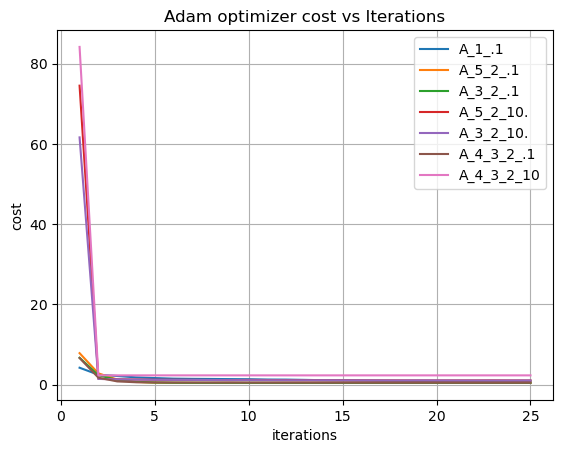

In [8]:
error_logs = [tuple([list(results[model][-1].history.values())[0],model]) for model in results] 
udr.plot_adam_cost(error_logs)

The next thing we have to determine is whether our models suffer from bias, variance, or both. In order to do so, we'll take a look at how the relationship between them changes across the parameter settings


In [7]:
model_train_cv_cost = [[model,stats[1:3]] for model,stats in results.items()]
model_train_cv_cost

[['A_1_.1', (0.20353535353535354, 0.21120448179271709)],
 ['A_5_2_.1', (0.11172438672438673, 0.12093837535014004)],
 ['A_3_2_.1', (0.10061327561327561, 0.10693277310924369)],
 ['A_5_2_10.', (0.2829004329004329, 0.2846638655462185)],
 ['A_3_2_10.', (0.18376623376623377, 0.18396358543417365)],
 ['A_4_3_2_.1', (0.09848484848484848, 0.1080532212885154)],
 ['A_4_3_2_10', (0.8875541125541125, 0.890266106442577)]]

What is the human level performance we could expect from such a task? 99.9% maybe? That'd correspond to a cost error in Jtrain or Jcv of around 0.01%, one order of magnitude below than what we are currenly getting. Therefore, and with this human baseline, we can infer that our algorithm currently experiences **high bias (or underfit)** We can try different things to sort this:
- Add more layers
- Add more neurons per layer
- Decrease values of the regularization parameter, lambda

After doing that, the next thing we can do is **Error analysis** => Analyze distributions of errors to see if there's a given category that is being misclassified more than others